In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from utils import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

## Load data

In [3]:
df_raw = feather.read_dataframe('tmp/raw')

df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

## Confidence based on tree variance

In [4]:
set_rf_samples(50000)

In [5]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [6]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20585224977507433, 0.24884931343067615, 0.9114382761078967, 0.8894087243149835, 0.8944326540492002]


Using the standard deviation of predictions: This tells us the relative confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent.

In [24]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.94 s, sys: 57.9 ms, total: 2 s
Wall time: 2 s


(10.447871772233839, 0.3602211975035565)

Using parallel processing to speed things up:

In [29]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds,n_jobs=4))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 66.8 ms, sys: 67.3 ms, total: 134 ms
Wall time: 642 ms


(10.447871772233839, 0.3602211975035565)

In [30]:
# apply to every predictor
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

In [31]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.899226,9.897575,0.277996
1,EROPS AC,9.305651,10.352299,0.578661
2,EROPS w AC,10.638201,10.584461,0.256923
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.876225,9.852393,0.241724


In [34]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.706515,9.777564,0.340480
Large,10.639695,10.508070,0.365790
Large / Medium,10.698560,10.657566,0.283330
Medium,10.728355,10.683018,0.285043
Mini,9.592279,9.607431,0.253054
Small,10.406021,10.334191,0.294981


## Feature Importances

In [7]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.178584
37,Coupler_System,0.115131
13,ProductSize,0.100464
14,fiProductClassDesc,0.075406
2,ModelID,0.058579
63,saleElapsed,0.050220
38,Grouser_Tracks,0.049745
10,fiSecondaryDesc,0.040881
8,fiModelDesc,0.033623
19,Enclosure,0.028410


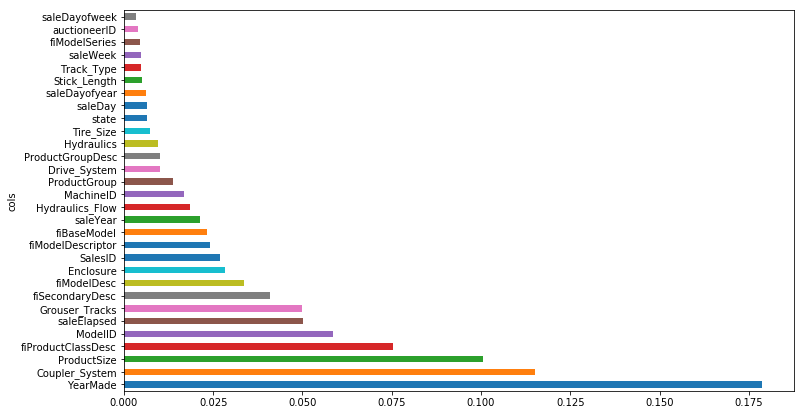

In [8]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [9]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [10]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [11]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2070408099355594, 0.24555468153573717, 0.9104126393480837, 0.8923176782487495, 0.8940660700826337]


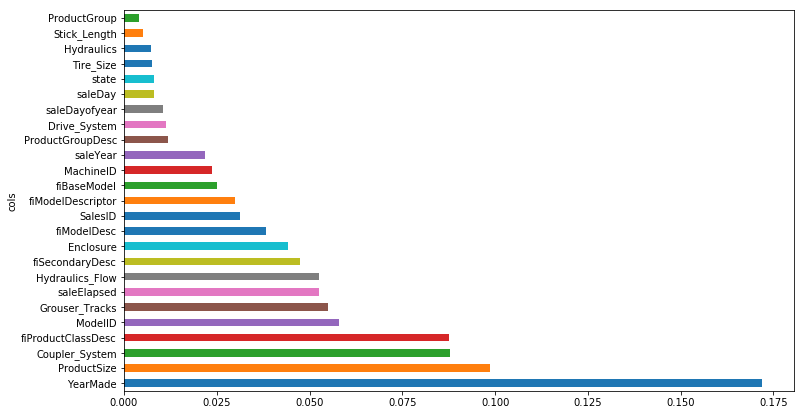

In [12]:
# some colinearity was removed: feature importances change
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional max_n_cat argument will turn some categorical variables into new columns. It will only happen to columns whose number of categories is no bigger than the value of the max_n_cat argument.

In [13]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20709596830844257, 0.2535031255299873, 0.9103648985062167, 0.8852336392010502, 0.892663875486045]


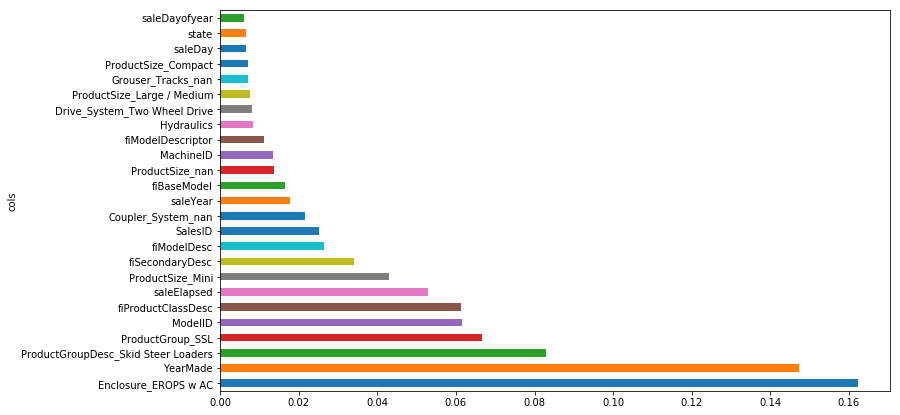

In [14]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

## Removing redundant features

In [15]:
from scipy.cluster import hierarchy as hc

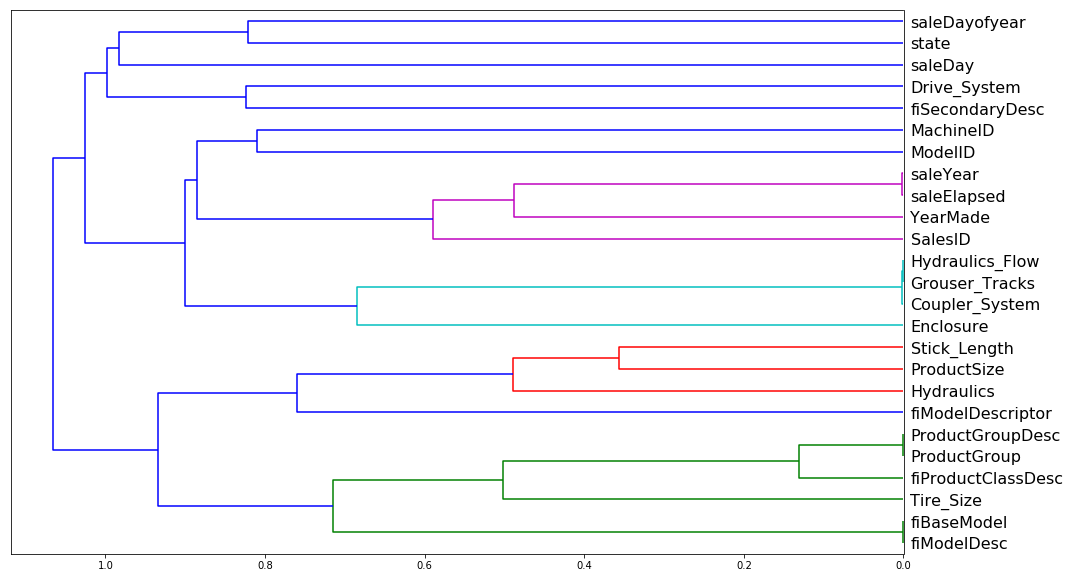

In [16]:
# rank correlation

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)

z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [17]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [18]:
# base score:
get_oob(df_keep)

0.8904589891175421

In [19]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8889748682072548
saleElapsed 0.8874311103442134
fiModelDesc 0.8885235010384793
fiBaseModel 0.889488485390141
Grouser_Tracks 0.8897393038596157
Coupler_System 0.8900475321579239


In [20]:
# looks like we can remove some features
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8889196829493563

In [21]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [22]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [23]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

### let's see how this model looks on the full dataset.

In [24]:
reset_rf_samples()
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12497550084854045, 0.22776406282164097, 0.9673574109257334, 0.9073557699833636, 0.9086987502184205]


## Partial dependence

In [25]:
from pdpbox import pdp
from plotnine import *

In [26]:
set_rf_samples(50000)

In [27]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

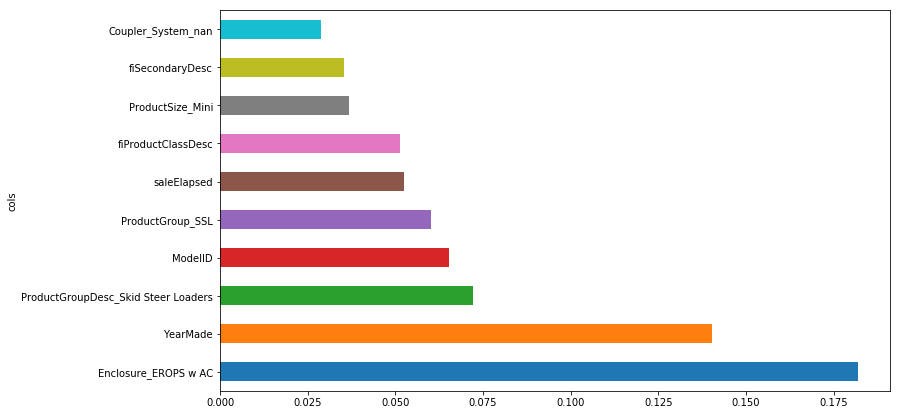

In [28]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

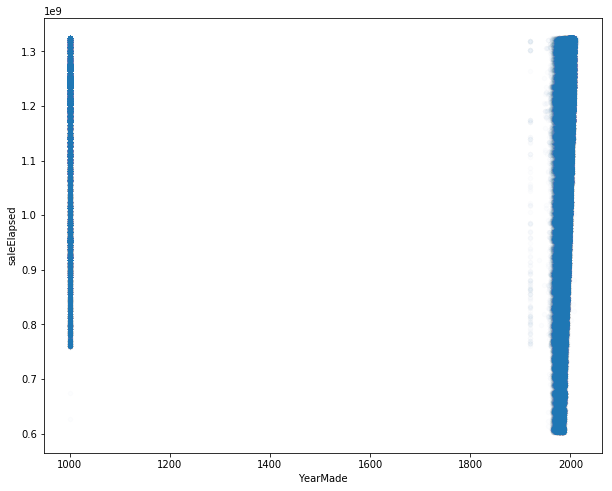

In [29]:
# agly plot: there seem to be a lot of buldozwrs made in 1000 !
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

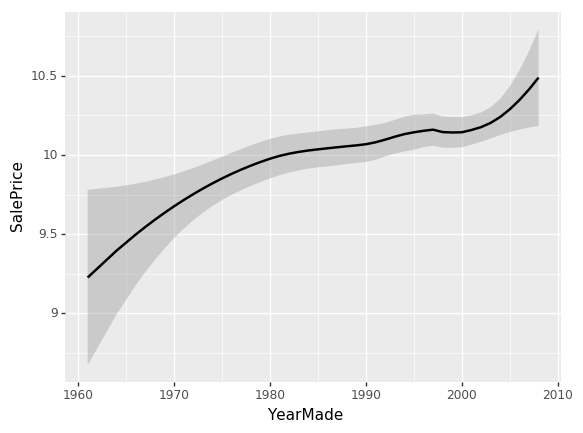

<ggplot: (7025232872)>

In [30]:
# let's remove those records
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

# and plot again
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [31]:
x = get_sample(X_train[X_train.YearMade>1930], 500)
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


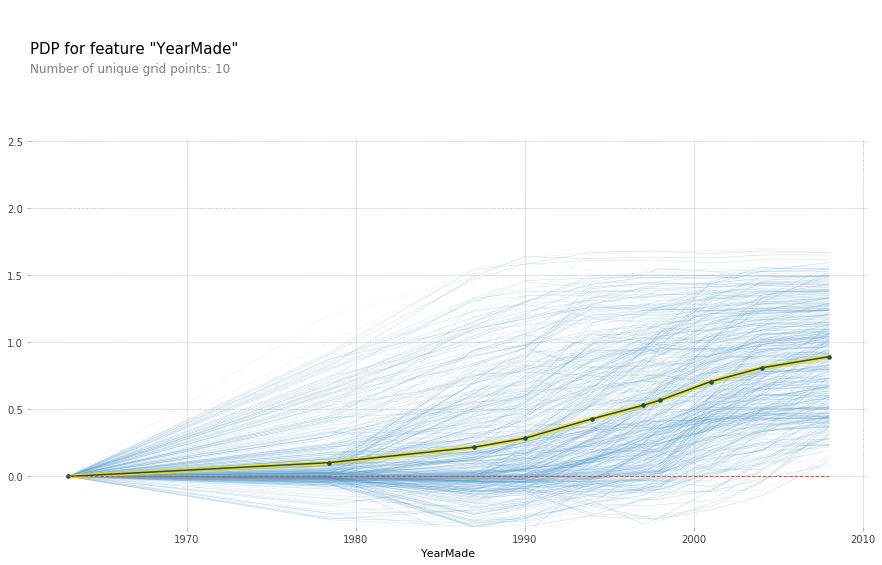

In [32]:
plot_pdp('YearMade');

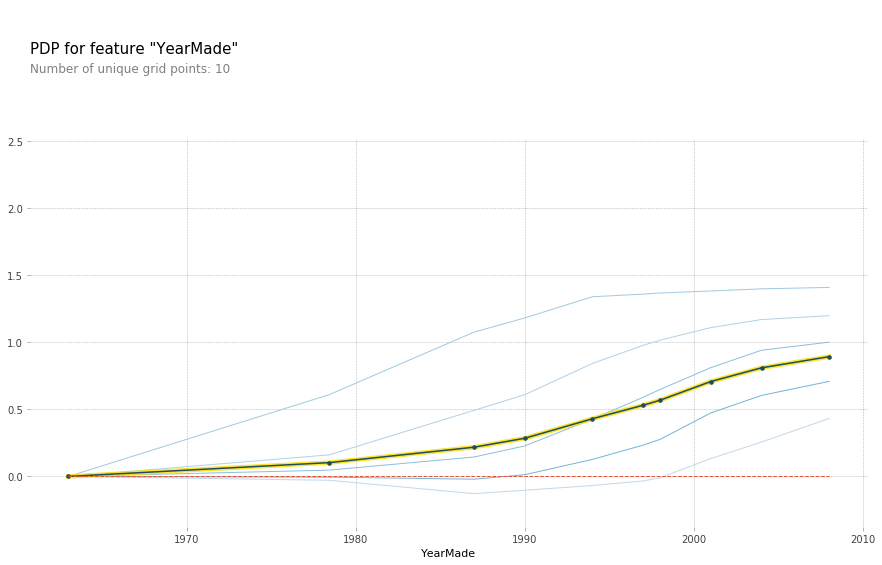

In [33]:
# exploring different behaviors
plot_pdp('YearMade', clusters=5);

In [35]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
#pdp.pdp_interact_plot(p, feats);

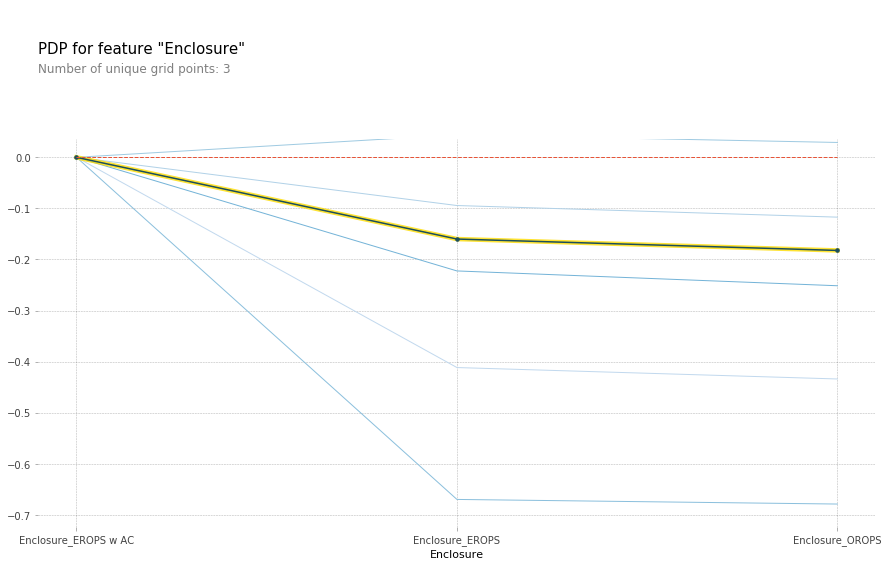

In [36]:
# Categorical variables: AC (air-conditioning) leads to higher price
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure');

In [37]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

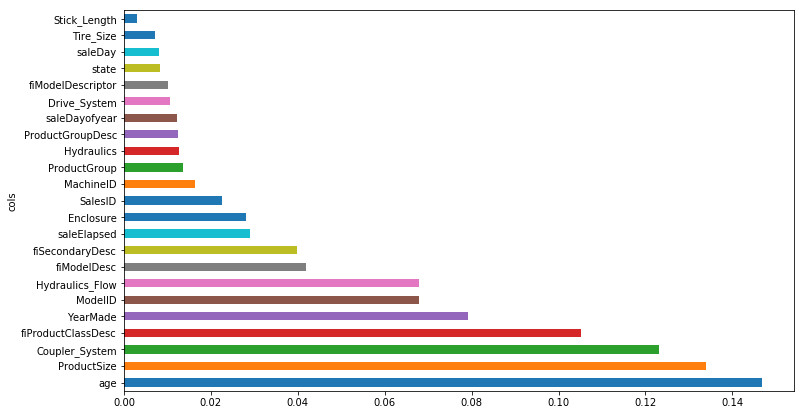

In [38]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

## Tree Interpreter

In [122]:
from treeinterpreter import treeinterpreter as ti

In [123]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [124]:
# pick up particular row
row = X_valid.values[None,0]; row

array([[      1997,          0,          4,         64, 1323993600,       5864,         31,          0,       3295,
                 0,          6,    6319984,    1923435,          0,         12,          1,          6,         16,
                 5,        350,          6,         14]])

In [125]:
# involving treeinterpreter
prediction, bias, contributions = ti.predict(m, row)

In [128]:
prediction[0], bias[0]

(array([10.371685]), 10.103050104046535)

In [130]:
idxs = np.argsort(contributions[0])
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('age', 14, -0.21208018651526372),
 ('ModelID', 5864, -0.17317796594028426),
 ('Enclosure', 'OROPS', -0.11326409029807097),
 ('fiSecondaryDesc', 'C', -0.03215825146090534),
 ('fiModelDescriptor', nan, -0.026071611885518698),
 ('saleDay', 16, -0.015734026589273052),
 ('state', 'California', -0.0036655511469168454),
 ('MachineID', 1923435, -0.0010635208848296164),
 ('SalesID', 6319984, 0.0008382637363804513),
 ('fiModelDesc', 'L120C', 0.003140134547486495),
 ('Tire_Size', '23.5', 0.00533256182896844),
 ('Hydraulics', '2 Valve', 0.005857056731990262),
 ('Drive_System', nan, 0.0071934031093268125),
 ('saleDayofyear', 350, 0.00953563268924924),
 ('ProductGroupDesc', 'Wheel Loader', 0.013457194966763763),
 ('ProductGroup', 'WL', 0.024447242320747974),
 ('Hydraulics_Flow', nan, 0.02918990769717835),
 ('Coupler_System', nan, 0.05988756056411724),
 ('saleElapsed', 1323993600, 0.07046431736905161),
 ('fiProductClassDesc',
  'Wheel Loader - 200.0 to 225.0 Horsepower',
  0.1472710642196066),
 ('Y

In [131]:
contributions[0].sum()

0.26863468310615485

In [132]:
# the same as 
prediction[0][0]- bias[0]

0.26863468310615346

## Extrapolation

* Random Forrest do not generalize.

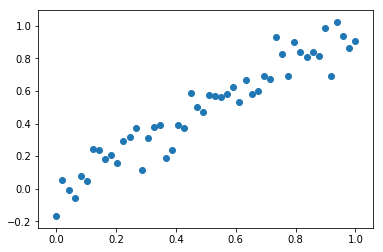

In [8]:
x = np.linspace(0,1)
y = x + 0.1*np.random.randn(x.shape[0])
plt.scatter(x,y);

In [42]:
x_trn, x_val = x[:40].reshape(-1,1), x[40:].reshape(-1,1)
y_trn, y_val = y[:40], y[40:]

m = RandomForestRegressor(n_estimators=10).fit(x_trn,y_trn)

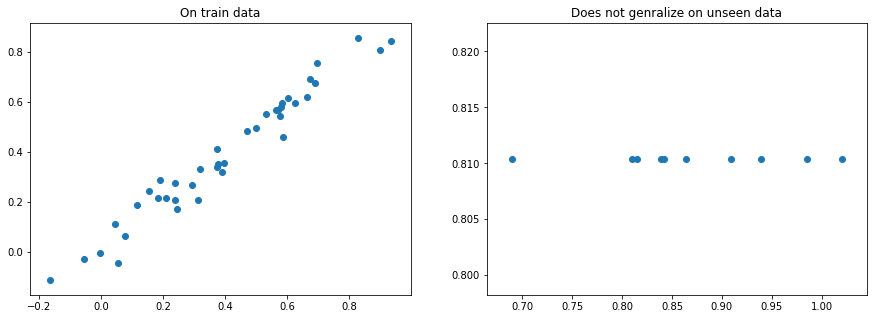

In [55]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
ax[0].scatter(y_trn,m.predict(x_trn))
ax[0].set_title('On train data')
ax[1].scatter(y_val,m.predict(x_val))
ax[1].set_title('Does not genralize on unseen data');

* We need to ensure that our variables are from random sample

In [39]:
# let's see if our model can predict validation set
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [40]:
# if you can predict the validation set, you do not have random sample
# high oob_score means that validation set is not a random sample
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999925210345902

In [41]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.778658
5,saleElapsed,0.150583
12,MachineID,0.063423
0,YearMade,0.002091
7,fiModelDesc,0.001272
4,ModelID,0.000960
20,saleDayofyear,0.000825
8,Enclosure,0.000637
1,Coupler_System,0.000478
6,fiSecondaryDesc,0.000476


In [42]:
# grab top 3
feats = ['saleElapsed','SalesID','MachineID']
(X_train[feats]/1000).describe()

,saleElapsed,SalesID,MachineID
count,3.891250e+05,389125.000000,389125.000000
mean,1.084797e+06,1800.452485,1206.796148
std,1.803913e+05,595.627288,430.850552
min,6.009984e+05,1139.246000,0.000000
25%,9.666432e+05,1413.348000,1087.016000
50%,1.134605e+06,1632.093000,1273.859000
75%,1.234138e+06,2210.453000,1458.661000
max,1.325117e+06,4364.741000,2313.821000


In [43]:
(X_valid[feats]/1000).describe()

,saleElapsed,SalesID,MachineID
count,1.200000e+04,12000.000000,12000.000000
mean,1.306609e+06,5786.967651,1578.049709
std,2.497808e+04,836.899608,589.497173
min,1.174522e+06,4364.751000,0.830000
25%,1.309219e+06,4408.580750,1271.225250
50%,1.316045e+06,6272.538500,1825.317000
75%,1.321402e+06,6291.792250,1907.858000
max,1.325203e+06,6333.342000,2486.330000


In [44]:
# different stats, so let's drop them
x.drop(feats, axis=1, inplace=True)
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9790813337488314

In [45]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.237374
0,YearMade,0.185388
17,saleDayofyear,0.155537
4,ModelID,0.079126
6,fiModelDesc,0.061125
16,saleDay,0.056225
15,state,0.054687
3,fiProductClassDesc,0.031943
5,fiSecondaryDesc,0.023215
7,Enclosure,0.021565


In [46]:
set_rf_samples(50000)
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [47]:
# Base score
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20788572294632648, 0.24780819416834457, 0.909679953115586, 0.8903321574635954, 0.8931597934210884]


In [48]:
# removing features to see if any change wrt the base score
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20885428157931465, 0.24552631194188737, 0.9088363737761727, 0.8923425584688549, 0.8925613814272687]
saleElapsed
[0.213948552758718, 0.255108583691684, 0.9043348994677045, 0.883775384716928, 0.887104082965194]
MachineID
[0.20663043861727706, 0.2447663683869251, 0.9107674259105789, 0.8930079614154888, 0.8949045806513912]
age
[0.2090927243813733, 0.24694436287149563, 0.9086280972807826, 0.8910954042001633, 0.8918923835358677]
YearMade
[0.20894497812957533, 0.25272430134734214, 0.9087571795971965, 0.8859377371400241, 0.892035419502864]
saleDayofyear
[0.2085811656592365, 0.24355664317739306, 0.9090746447651249, 0.8940629357526965, 0.8929537301190931]


In [49]:
reset_rf_samples()

In [50]:
# dropping suspicious variables
df_subs = df_keep.drop(['SalesID', 'MachineID','saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1372833175056815, 0.2180723766531427, 0.9606114170223883, 0.9150723147187336, 0.909095388302196]


now r^2 score on valid set is higher than oob score

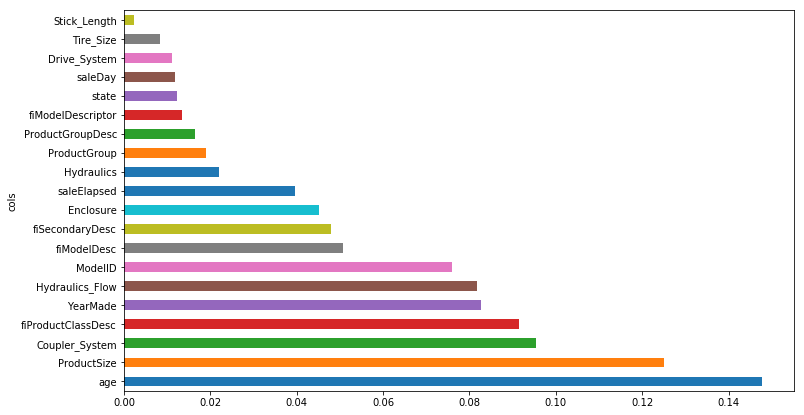

In [51]:
plot_fi(rf_feat_importance(m, X_train));

In [52]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

## Final Model

In [53]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4min 43s, sys: 5.38 s, total: 4min 48s
Wall time: 47.1 s
[0.07998711910669343, 0.21109574926901756, 0.9866286598672427, 0.9204194474165585, 0.9145536810594483]
